# Customer Segmentation Analysis Project Report
#### ANA555 PRACTICUM IN APPLIED ANALYTICS
##### WILLIAM EDGAR KOROMPIS ID: 1124269

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlite3
import matplotlib.pyplot as plt 
from sklearn.tree import DecisionTreeClassifier # to build a classification tree
from sklearn.tree import plot_tree # to draw a classification tree
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score # for cross validation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
import tkinter as tk
from tkinter import filedialog

## Data Cleaning and Merging (SQL)

In [8]:
# Hide the main window
root = tk.Tk()
root.withdraw()

# Open file dialog to select a CSV file
file_path = filedialog.askopenfilename(filetypes=[("All files", "*.*")])

# Show the selected file name
print(f"Selected file: {file_path}")

# List all sheet names to understand the data structure
xls = pd.ExcelFile(file_path)
raw_sheet_names = xls.sheet_names

raw_sheet_names

Selected file: C:/Users/willi/OneDrive/Desktop/Capstone Project/Bike Store Dataset.xlsx


['Transactions', 'NewCustomerList', 'CustomerDemographic', 'CustomerAddress']

In [10]:
# Load a sample of each sheet to inspect their columns and data types
transactions_raw = pd.read_excel(file_path, sheet_name='Transactions')
new_customer_raw = pd.read_excel(file_path, sheet_name='NewCustomerList')
demographics_raw = pd.read_excel(file_path, sheet_name='CustomerDemographic')
address_raw = pd.read_excel(file_path, sheet_name='CustomerAddress')

# Display columns of each sheet
{
    "Transactions": transactions_raw.columns.tolist(),
    "NewCustomerList": new_customer_raw.columns.tolist(),
    "CustomerDemographic": demographics_raw.columns.tolist(),
    "CustomerAddress": address_raw.columns.tolist()
}

{'Transactions': ['transaction_id',
  'product_id',
  'customer_id',
  'transaction_date',
  'online_order',
  'order_status',
  'brand',
  'product_line',
  'product_class',
  'product_size',
  'list_price',
  'standard_cost',
  'product_first_sold_date'],
 'NewCustomerList': ['first_name',
  'last_name',
  'gender',
  'past_3_years_bike_related_purchases',
  'DOB',
  'job_title',
  'job_industry_category',
  'wealth_segment',
  'deceased_indicator',
  'owns_car',
  'tenure',
  'address',
  'postcode',
  'state',
  'country',
  'property_valuation',
  'Unnamed: 16',
  'Unnamed: 17',
  'Unnamed: 18',
  'Unnamed: 19',
  'Unnamed: 20',
  'Rank',
  'Value'],
 'CustomerDemographic': ['customer_id',
  'first_name',
  'last_name',
  'gender',
  'past_3_years_bike_related_purchases',
  'DOB',
  'job_title',
  'job_industry_category',
  'wealth_segment',
  'deceased_indicator',
  'default',
  'owns_car',
  'tenure'],
 'CustomerAddress': ['customer_id',
  'address',
  'postcode',
  'state',
  '

In [12]:
# Clean the CustomerDemographic: drop "default" and convert DOB to string
demographics_cleaned = demographics_raw.drop(columns=['default'], errors='ignore')
demographics_cleaned['DOB'] = demographics_cleaned['DOB'].astype(str)

# Clean NewCustomerList: drop unwanted columns
columns_to_drop = [col for col in new_customer_raw.columns if 'Unnamed' in col or col in ['Rank', 'Value']]
new_customer_cleaned = new_customer_raw.drop(columns=columns_to_drop, errors='ignore')

In [14]:
# Recreate the in-memory SQLite database
import sqlite3
conn = sqlite3.connect(':memory:')

# Load dataframes into SQLite with the correct data types
transactions_raw.to_sql('Transactions', conn, index=False, if_exists='replace')
new_customer_cleaned.to_sql('NewCustomerList', conn, index=False, if_exists='replace')
demographics_cleaned.to_sql('CustomerDemographic', conn, index=False, if_exists='replace')
address_raw.to_sql('CustomerAddress', conn, index=False, if_exists='replace')

3999

In [16]:
# Step 1: Clean CustomerDemographic and calculate age
conn.execute("""
CREATE TABLE CleanedCustomerDemographic AS
SELECT DISTINCT
    customer_id,
    first_name,
    last_name,
    gender,
    past_3_years_bike_related_purchases,
    DOB,
    job_title,
    job_industry_category,
    wealth_segment,
    deceased_indicator,
    owns_car,
    tenure,
    (CAST(strftime('%Y', 'now') AS INTEGER) - CAST(strftime('%Y', DOB) AS INTEGER)) AS age
FROM CustomerDemographic
WHERE deceased_indicator != 'Y'
      AND customer_id IS NOT NULL
      AND gender IS NOT NULL
""")

In [18]:
# Step 2: Clean CustomerAddress
conn.execute("""
CREATE TABLE CleanedCustomerAddress AS
SELECT DISTINCT
    customer_id,
    address,
    postcode,
    UPPER(state) AS state,
    UPPER(country) AS country,
    property_valuation
FROM CustomerAddress
WHERE state IS NOT NULL
      AND country IS NOT NULL
""")

In [20]:
# Step 3: Clean Transactions
conn.execute("""
CREATE TABLE CleanedTransactions AS
SELECT DISTINCT
    transaction_id,
    product_id,
    customer_id,
    transaction_date,
    online_order,
    order_status,
    brand,
    product_line,
    product_class,
    product_size,
    list_price,
    standard_cost,
    product_first_sold_date
FROM Transactions
WHERE order_status = 'Approved'
      AND list_price IS NOT NULL
      AND customer_id IS NOT NULL
""")

In [22]:
# Step 4: Final Aggregated Customer Segmentation Dataset
query = """
SELECT
    t.customer_id,
    CASE 
        WHEN LOWER(cd.gender) IN ('m', 'male') THEN 'Male'
        WHEN LOWER(cd.gender) IN ('f', 'female') THEN 'Female'
        ELSE NULL
    END AS gender,
    cd.age,
    cd.past_3_years_bike_related_purchases,
    cd.job_industry_category,
    cd.wealth_segment,
    cd.owns_car,
    CASE 
        WHEN LOWER(ca.state) IN ('new south wales', 'nsw') THEN 'NSW'
        WHEN LOWER(ca.state) IN ('victoria', 'vic') THEN 'VIC'
        WHEN LOWER(ca.state) IN ('qld', 'queensland') THEN 'QLD'
        ELSE NULL
    END AS state,
    ca.country,
    ca.property_valuation,
    SUM(t.list_price) AS total_spent,
    COUNT(t.transaction_id) AS transaction_count,
    MAX(t.transaction_date) AS most_recent_purchase,
    MIN(t.transaction_date) AS first_purchase
FROM
    CleanedTransactions t
LEFT JOIN CleanedCustomerDemographic cd ON t.customer_id = cd.customer_id
LEFT JOIN CleanedCustomerAddress ca ON t.customer_id = ca.customer_id
GROUP BY
    t.customer_id,
    cd.gender,
    cd.age,
    cd.past_3_years_bike_related_purchases,
    cd.job_industry_category,
    cd.wealth_segment,
    cd.owns_car,
    ca.state,
    ca.country,
    ca.property_valuation
"""

In [28]:
final_df = pd.read_sql_query(query, conn)

# Export as CSV
csv_path = "C:/Users/willi/OneDrive/Desktop/Capstone Project/final_customer_segmentation_dataset.csv"
final_df.to_csv(csv_path, index=False)

csv_path

'C:/Users/willi/OneDrive/Desktop/Capstone Project/final_customer_segmentation_dataset.csv'

## Data Pre-processing (Python)

In [37]:
# After running the block below, choose the new csv file generated from the previous section, "final_customer_segmentation_dataset"

In [36]:
# Hide the main window
root = tk.Tk()
root.withdraw()

# Open file dialog to select a CSV file
file_path = filedialog.askopenfilename(filetypes=[("All files", "*.*")])

# Show the selected file name
print(f"Selected file: {file_path}")

Selected file: C:/Users/willi/OneDrive/Desktop/Capstone Project/final_customer_segmentation_dataset.csv


In [40]:
# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame 
df.shape

(3493, 14)

In [42]:
# Dataset Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3493 entries, 0 to 3492
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          3493 non-null   int64  
 1   gender                               3413 non-null   object 
 2   age                                  3415 non-null   float64
 3   past_3_years_bike_related_purchases  3491 non-null   float64
 4   job_industry_category                2930 non-null   object 
 5   wealth_segment                       3491 non-null   object 
 6   owns_car                             3491 non-null   object 
 7   state                                3488 non-null   object 
 8   country                              3488 non-null   object 
 9   property_valuation                   3488 non-null   float64
 10  total_spent                          3493 non-null   float64
 11  transaction_count             

In [44]:
# Summary statistics
df.describe(include='all')

,customer_id,gender,age,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,owns_car,state,country,property_valuation,total_spent,transaction_count,most_recent_purchase,first_purchase
count,3493.000000,3413,3415.000000,3491.000000,2930,3491,3491,3488,3488,3488.000000,3493.000000,3493.000000,3493,3493
unique,NaN,2,NaN,NaN,9,3,2,3,1,NaN,NaN,NaN,277,282
top,NaN,Female,NaN,NaN,Manufacturing,Mass Customer,Yes,NSW,AUSTRALIA,NaN,NaN,NaN,2017-12-19 00:00:00,2017-01-05 00:00:00
freq,NaN,1757,NaN,NaN,702,1747,1769,1865,3488,NaN,NaN,NaN,59,61
mean,1751.275122,NaN,47.867057,48.799198,NaN,NaN,NaN,NaN,NaN,7.515768,6285.198022,5.674492,NaN,NaN
std,1011.744104,NaN,12.794391,28.598817,NaN,NaN,NaN,NaN,NaN,2.822801,2941.998917,2.311440,NaN,NaN
min,1.000000,NaN,23.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000,60.340000,1.000000,NaN,NaN
25%,877.000000,NaN,38.000000,24.000000,NaN,NaN,NaN,NaN,NaN,6.000000,4162.960000,4.000000,NaN,NaN
50%,1751.000000,NaN,48.000000,48.000000,NaN,NaN,NaN,NaN,NaN,8.000000,5974.770000,6.000000,NaN,NaN
75%,2625.000000,NaN,57.000000,73.000000,NaN,NaN,NaN,NaN,NaN,10.000000,8157.720000,7.000000,NaN,NaN


### Missing Values Handling 

In [46]:
# Check missing values
missing_values = df.isnull().sum()
missing_values

customer_id                              0
gender                                  80
age                                     78
past_3_years_bike_related_purchases      2
job_industry_category                  563
wealth_segment                           2
owns_car                                 2
state                                    5
country                                  5
property_valuation                       5
total_spent                              0
transaction_count                        0
most_recent_purchase                     0
first_purchase                           0
dtype: int64

In [48]:
# Impute categorical features with 'Unknown' or mode
df['job_industry_category'].fillna('Unknown', inplace=True)
df['age'].fillna(df['age'].median(), inplace=True)

In [50]:
df = df.dropna(subset=['state', 'country', 'property_valuation', 'gender', 'owns_car', 'wealth_segment', 'past_3_years_bike_related_purchases'])

In [52]:
df.isnull().sum()

customer_id                            0
gender                                 0
age                                    0
past_3_years_bike_related_purchases    0
job_industry_category                  0
wealth_segment                         0
owns_car                               0
state                                  0
country                                0
property_valuation                     0
total_spent                            0
transaction_count                      0
most_recent_purchase                   0
first_purchase                         0
dtype: int64

### Feature Engineering 

In [55]:
# Drop customerID as it's not useful for modeling
df.drop('customer_id', axis=1, inplace=True)

# Focusing only riders age 80 or younger
df = df[df["age"] <= 80]

In [57]:
# Converting to datetime format 
df['first_purchase'] = pd.to_datetime(df['first_purchase'])
df['most_recent_purchase'] = pd.to_datetime(df['most_recent_purchase'])

In [59]:
reference_date = df['most_recent_purchase'].max()

df['days_since_last_purchase'] = (reference_date - df['most_recent_purchase']).dt.days
df['customer_tenure_days'] = (df['most_recent_purchase'] - df['first_purchase']).dt.days

In [61]:
df_for_profiling = df.copy()

In [63]:
df.drop(['first_purchase', 'most_recent_purchase'], axis=1, inplace=True)

#### Selecting Features + Scalling and One-hot encoding 

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3404 entries, 0 to 3491
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   gender                               3404 non-null   object 
 1   age                                  3404 non-null   float64
 2   past_3_years_bike_related_purchases  3404 non-null   float64
 3   job_industry_category                3404 non-null   object 
 4   wealth_segment                       3404 non-null   object 
 5   owns_car                             3404 non-null   object 
 6   state                                3404 non-null   object 
 7   country                              3404 non-null   object 
 8   property_valuation                   3404 non-null   float64
 9   total_spent                          3404 non-null   float64
 10  transaction_count                    3404 non-null   int64  
 11  days_since_last_purchase           

In [68]:
df.describe(include='all')

,gender,age,past_3_years_bike_related_purchases,job_industry_category,wealth_segment,owns_car,state,country,property_valuation,total_spent,transaction_count,days_since_last_purchase,customer_tenure_days
count,3404,3404.000000,3404.000000,3404,3404,3404,3404,3404,3404.000000,3404.000000,3404.000000,3404.000000,3404.000000
unique,2,NaN,NaN,10,3,2,3,1,NaN,NaN,NaN,NaN,NaN
top,Female,NaN,NaN,Manufacturing,Mass Customer,Yes,NSW,AUSTRALIA,NaN,NaN,NaN,NaN,NaN
freq,1753,NaN,NaN,698,1699,1719,1819,3404,NaN,NaN,NaN,NaN,NaN
mean,NaN,47.764982,48.967685,NaN,NaN,NaN,NaN,NaN,7.518214,6266.369891,5.667450,61.441246,239.782902
std,NaN,12.502859,28.653084,NaN,NaN,NaN,NaN,NaN,2.822284,2937.251726,2.310433,58.051932,81.849156
min,NaN,23.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000,60.340000,1.000000,0.000000,0.000000
25%,NaN,38.000000,24.000000,NaN,NaN,NaN,NaN,NaN,6.000000,4154.767500,4.000000,18.000000,194.750000
50%,NaN,48.000000,48.000000,NaN,NaN,NaN,NaN,NaN,8.000000,5961.015000,6.000000,44.000000,257.000000
75%,NaN,57.000000,73.000000,NaN,NaN,NaN,NaN,NaN,10.000000,8130.665000,7.000000,86.000000,302.000000


In [70]:
# Identify categorical columns
categorical_cols = ['gender', 'job_industry_category', 'wealth_segment', 'owns_car', 'state', 'country']

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Show result
print("Shape after encoding:", df_encoded.shape)
df_encoded.head()

Shape after encoding: (3404, 22)


,age,past_3_years_bike_related_purchases,property_valuation,total_spent,transaction_count,days_since_last_purchase,customer_tenure_days,gender_Male,job_industry_category_Entertainment,job_industry_category_Financial Services,...,job_industry_category_Manufacturing,job_industry_category_Property,job_industry_category_Retail,job_industry_category_Telecommunications,job_industry_category_Unknown,wealth_segment_High Net Worth,wealth_segment_Mass Customer,owns_car_Yes,state_QLD,state_VIC
0,72.0,93.0,10.0,9084.45,11,7,352,False,False,False,...,False,False,False,False,False,False,True,True,False,False
1,45.0,81.0,10.0,4149.07,3,128,112,True,False,True,...,False,False,False,False,False,False,True,True,False,False
3,64.0,33.0,9.0,1047.72,2,195,76,True,False,False,...,False,False,False,False,False,False,True,False,True,False
4,48.0,56.0,4.0,5903.20,6,16,286,False,False,False,...,False,False,False,False,True,False,False,True,False,False
5,59.0,35.0,9.0,5931.69,5,64,272,True,False,False,...,False,False,True,False,False,True,False,True,False,True


In [72]:
from sklearn.preprocessing import StandardScaler

selected_features = [
    'age',
    'past_3_years_bike_related_purchases',
    'property_valuation',
    'total_spent',
    'transaction_count',
    'days_since_last_purchase',
    'customer_tenure_days'
]

#### Outlier Handling 

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3404 entries, 0 to 3491
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   gender                               3404 non-null   object 
 1   age                                  3404 non-null   float64
 2   past_3_years_bike_related_purchases  3404 non-null   float64
 3   job_industry_category                3404 non-null   object 
 4   wealth_segment                       3404 non-null   object 
 5   owns_car                             3404 non-null   object 
 6   state                                3404 non-null   object 
 7   country                              3404 non-null   object 
 8   property_valuation                   3404 non-null   float64
 9   total_spent                          3404 non-null   float64
 10  transaction_count                    3404 non-null   int64  
 11  days_since_last_purchase           

In [77]:
df_no_outliers = df_encoded.copy()

# IQR-based outlier removal
for col in selected_features:
    Q1 = df_no_outliers[col].quantile(0.25)
    Q3 = df_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]

print("Before outlier removal:", df_encoded.shape)
print("After outlier removal:", df_no_outliers.shape)

Before outlier removal: (3404, 22)
After outlier removal: (3125, 22)


In [79]:
df = df_no_outliers

#### Scaling 

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3125 entries, 0 to 3491
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   age                                       3125 non-null   float64
 1   past_3_years_bike_related_purchases       3125 non-null   float64
 2   property_valuation                        3125 non-null   float64
 3   total_spent                               3125 non-null   float64
 4   transaction_count                         3125 non-null   int64  
 5   days_since_last_purchase                  3125 non-null   int64  
 6   customer_tenure_days                      3125 non-null   int64  
 7   gender_Male                               3125 non-null   bool   
 8   job_industry_category_Entertainment       3125 non-null   bool   
 9   job_industry_category_Financial Services  3125 non-null   bool   
 10  job_industry_category_Health             

In [83]:
# Scale the features
scaler = StandardScaler()
df[selected_features] = scaler.fit_transform(df[selected_features])

In [85]:
df.head()

,age,past_3_years_bike_related_purchases,property_valuation,total_spent,transaction_count,days_since_last_purchase,customer_tenure_days,gender_Male,job_industry_category_Entertainment,job_industry_category_Financial Services,...,job_industry_category_Manufacturing,job_industry_category_Property,job_industry_category_Retail,job_industry_category_Telecommunications,job_industry_category_Unknown,wealth_segment_High Net Worth,wealth_segment_Mass Customer,owns_car_Yes,state_QLD,state_VIC
0,1.925863,1.525282,0.878791,1.030492,2.549163,-1.036171,1.505132,False,False,False,...,False,False,False,False,False,False,True,True,False,False
1,-0.227183,1.106362,0.878791,-0.830305,-1.343640,1.664181,-2.082764,True,False,True,...,False,False,False,False,False,False,True,True,False,False
4,0.012044,0.233612,-1.240207,-0.168941,0.116161,-0.835318,0.518460,False,False,False,...,False,False,False,False,True,False,False,True,False,False
5,0.889211,-0.499498,0.525625,-0.158200,-0.370439,0.235896,0.309167,True,False,False,...,False,False,True,False,False,True,False,True,False,True
7,1.208181,-0.639138,-1.240207,2.139084,2.062562,-0.701417,1.295838,True,False,False,...,False,False,False,False,True,False,True,False,False,False


## Modeling 

### Determining optimal number of clusters with Elbow and Silhouette score method

In [89]:
from sklearn.cluster import KMeans

# Elbow method for K = 2 to 10
sse = []
k_range = range(2, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(df)
    sse.append(km.inertia_)

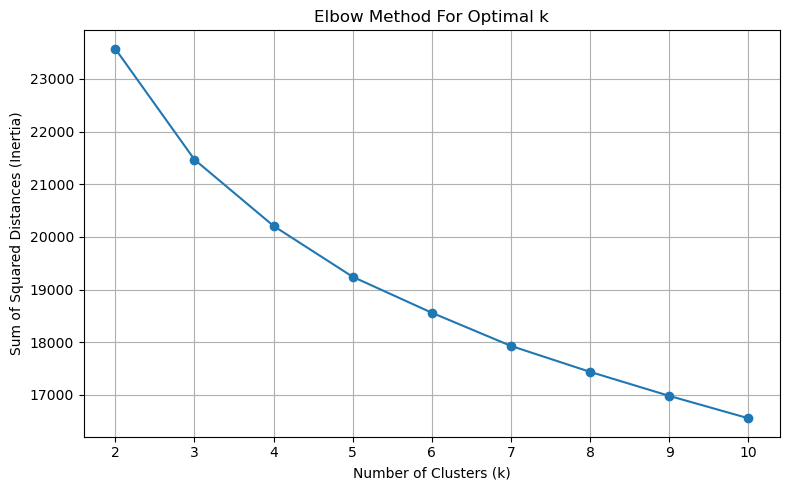

In [91]:
# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [93]:
# Comparing silhouette score for different values of k 
from sklearn.metrics import silhouette_score

for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = km.fit_predict(df)
    score = silhouette_score(df, cluster_labels)
    print(f"Silhouette Score for k={k}: {score:.4f}")

Silhouette Score for k=2: 0.1533
Silhouette Score for k=3: 0.1151
Silhouette Score for k=4: 0.1117
Silhouette Score for k=5: 0.1009
Silhouette Score for k=6: 0.0939
Silhouette Score for k=7: 0.0914
Silhouette Score for k=8: 0.0862
Silhouette Score for k=9: 0.0872
Silhouette Score for k=10: 0.0897


### Fit the Model with k=3

In [97]:
# Fit model and assign clusters
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans_final.fit_predict(df)

### Reduce Dimensions with PCA 

In [100]:
from sklearn.decomposition import PCA

# Reduce to 2D for plotting
pca = PCA(n_components=2)
components = pca.fit_transform(df.drop('cluster', axis=1))

# Add to DataFrame
df['pc1'] = components[:, 0]
df['pc2'] = components[:, 1]

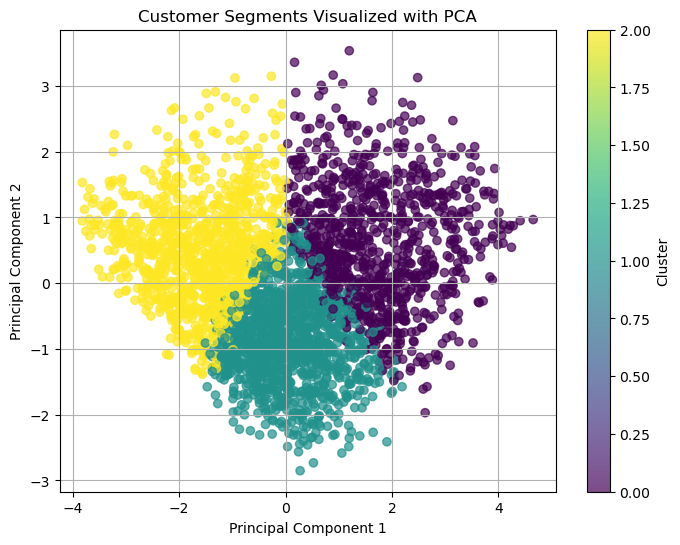

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['pc1'], df['pc2'], c=df['cluster'], cmap='viridis', alpha=0.7)
plt.title("Customer Segments Visualized with PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

## Results Profiling 

### Clustering Profiling 

In [106]:
df_for_profiling_no_outliers = df_for_profiling.loc[df_no_outliers.index].copy()

In [108]:
# Attach cluster labels to the readable, raw-format dataframe
df_for_profiling_no_outliers['cluster'] = df_no_outliers['cluster'].values

In [110]:
# Map numeric clusters to readable names (for Tableau / reports)
cluster_name_map = {
    0: "Balanced Mid-Value Buyers",
    1: "High-Value Frequent Loyalists",
    2: "At-Risk or Infrequent Buyers"
}

# Add name column to both the modeling DF (if you use it) and the export DF
df['cluster_name'] = df['cluster'].map(cluster_name_map)
df_for_profiling_no_outliers['cluster_name'] = df_for_profiling_no_outliers['cluster'].map(cluster_name_map)

In [112]:
cluster_summary = df_for_profiling_no_outliers.groupby('cluster').agg({
    'age': 'mean',
    'past_3_years_bike_related_purchases': 'mean',
    'total_spent': 'mean',
    'transaction_count': 'mean',
    'gender': lambda x: x.mode()[0] if not x.mode().empty else None,
    'job_industry_category': lambda x: x.mode()[0] if not x.mode().empty else None,
    'state': lambda x: x.mode()[0] if not x.mode().empty else None,
    'owns_car': lambda x: x.mode()[0] if not x.mode().empty else None
}).reset_index()

Text(0.5, 1.0, 'Average Feature Values by Cluster')

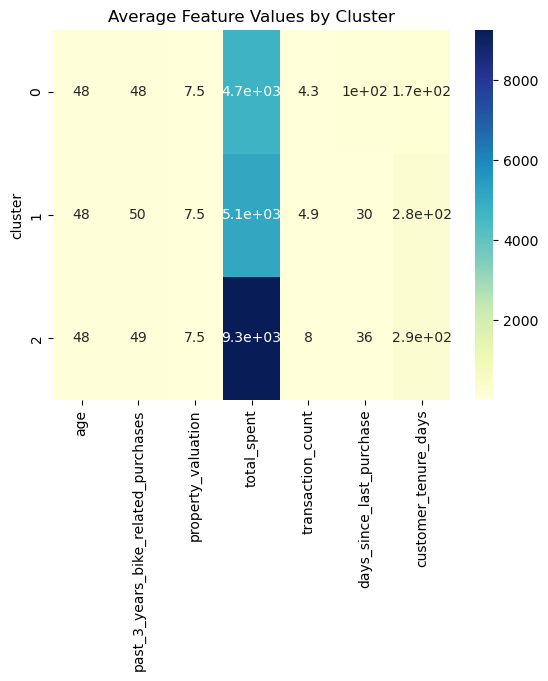

In [114]:
cluster_means = df_for_profiling_no_outliers.groupby('cluster')[selected_features].mean()
sns.heatmap(cluster_means, annot=True, cmap='YlGnBu')
plt.title("Average Feature Values by Cluster")

### Categorical Profiling

In [117]:
# List of categorical columns to profile
cat_cols = [
    "gender",
    "job_industry_category",
    "wealth_segment",
    "owns_car",
    "state"
]

with pd.ExcelWriter("cluster_categorical_breakdowns.xlsx") as writer:
    for col in cat_cols:
        ct = (pd.crosstab(
                df_for_profiling_no_outliers["cluster"],
                df_for_profiling_no_outliers[col],
                normalize="index"
             ) * 100
            ).round(1)
        ct.to_excel(writer, sheet_name=col)

In [119]:
from itables import show

for col in cat_cols:
    tab = pd.crosstab(df_for_profiling_no_outliers["cluster"], 
                      df_for_profiling_no_outliers[col], 
                      normalize="index") * 100
    tab = tab.round(2).reset_index()
    print(f"\n{col} distribution by cluster:")
    tab.columns.name = None
    show(tab)  # interactive for each category


gender distribution by cluster:


Loading ITables v2.4.4 from the internet... (need help?)



job_industry_category distribution by cluster:


Loading ITables v2.4.4 from the internet... (need help?)



wealth_segment distribution by cluster:


Loading ITables v2.4.4 from the internet... (need help?)



owns_car distribution by cluster:


Loading ITables v2.4.4 from the internet... (need help?)



state distribution by cluster:


Loading ITables v2.4.4 from the internet... (need help?)


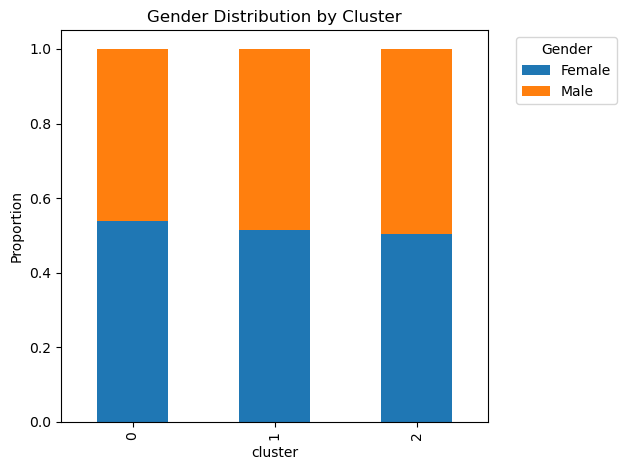

In [121]:
df_for_profiling_no_outliers.groupby('cluster')['gender'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)

plt.title("Gender Distribution by Cluster")
plt.ylabel("Proportion")
plt.legend(title="Gender", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

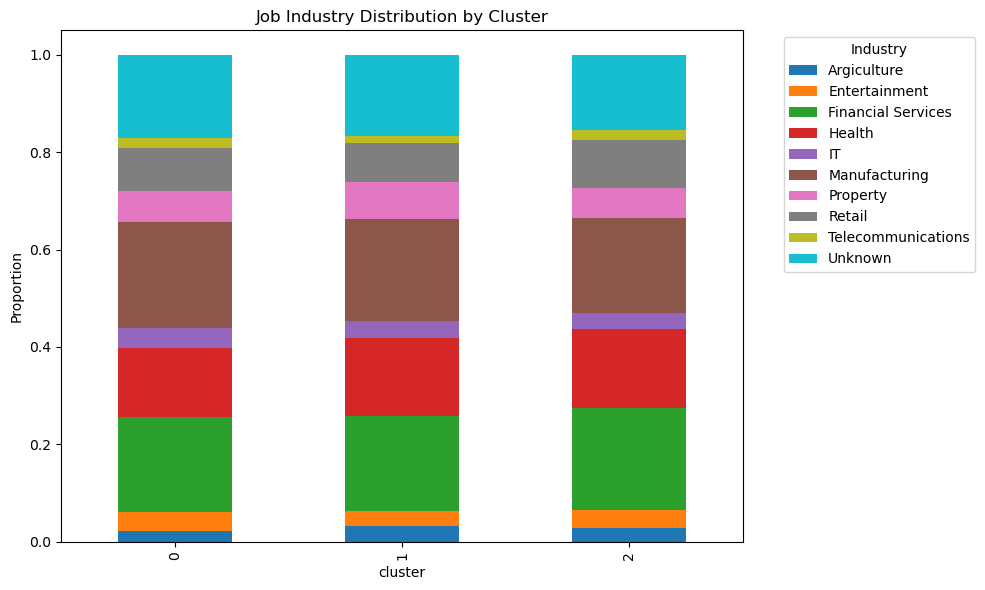

In [123]:
df_for_profiling_no_outliers.groupby('cluster')['job_industry_category'].value_counts(normalize=True).unstack().plot(
    kind='bar', stacked=True, figsize=(10, 6)
)
plt.title("Job Industry Distribution by Cluster")
plt.ylabel("Proportion")
plt.legend(title="Industry", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

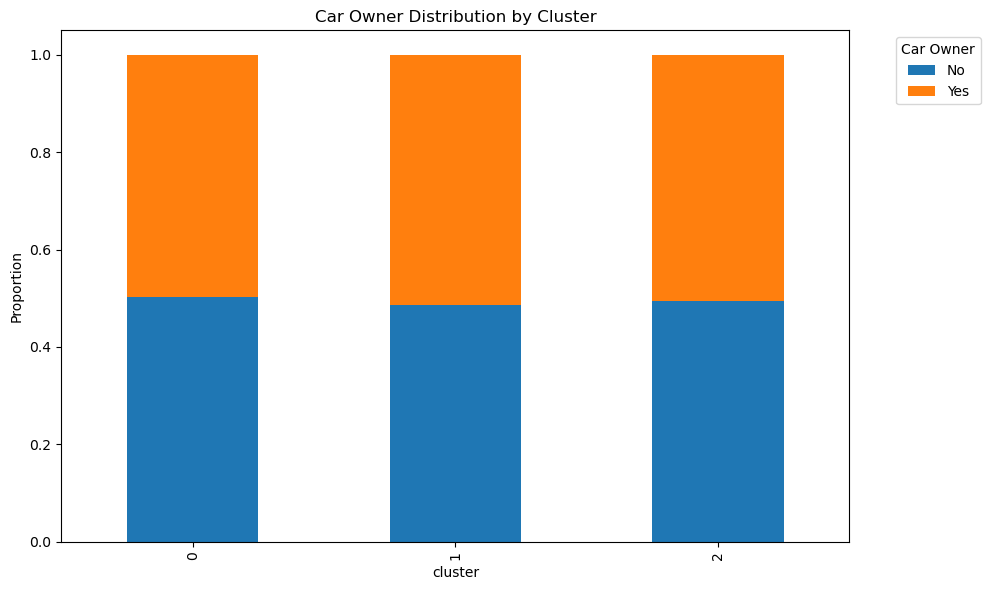

In [125]:
df_for_profiling_no_outliers.groupby('cluster')['owns_car'].value_counts(normalize=True).unstack().plot(
    kind='bar', stacked=True, figsize=(10, 6)
)
plt.title("Car Owner Distribution by Cluster")
plt.ylabel("Proportion")
plt.legend(title="Car Owner", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

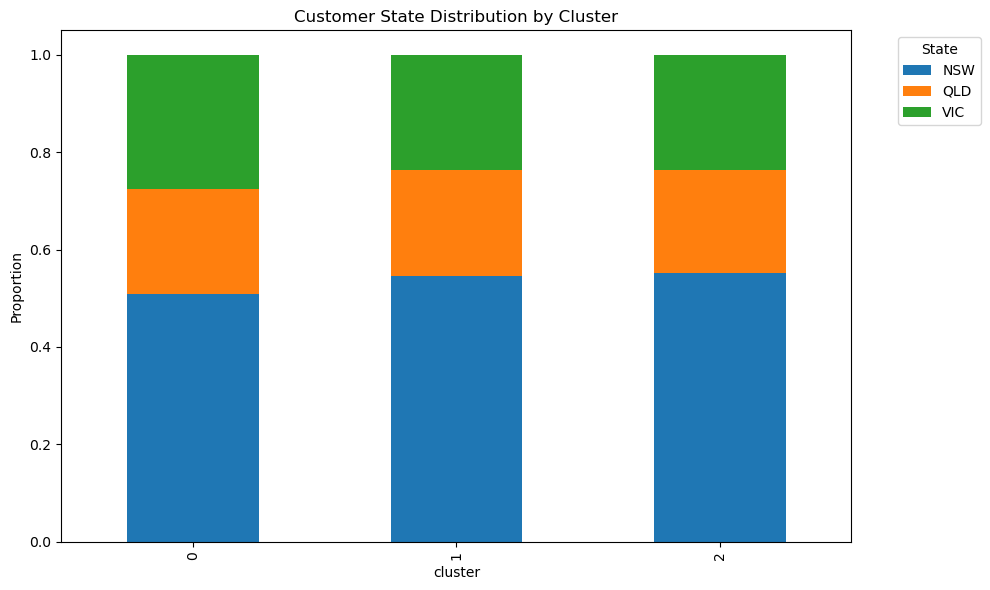

In [127]:
df_for_profiling_no_outliers.groupby('cluster')['state'].value_counts(normalize=True).unstack().plot(
    kind='bar', stacked=True, figsize=(10, 6)
)
plt.title("Customer State Distribution by Cluster")
plt.ylabel("Proportion")
plt.legend(title="State", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

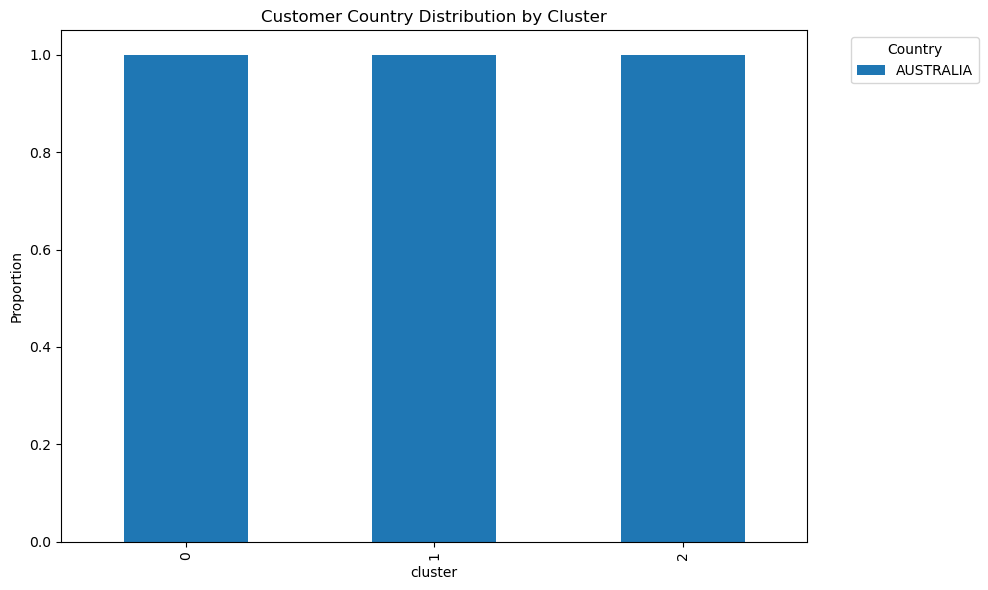

In [129]:
df_for_profiling_no_outliers.groupby('cluster')['country'].value_counts(normalize=True).unstack().plot(
    kind='bar', stacked=True, figsize=(10, 6)
)
plt.title("Customer Country Distribution by Cluster")
plt.ylabel("Proportion")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

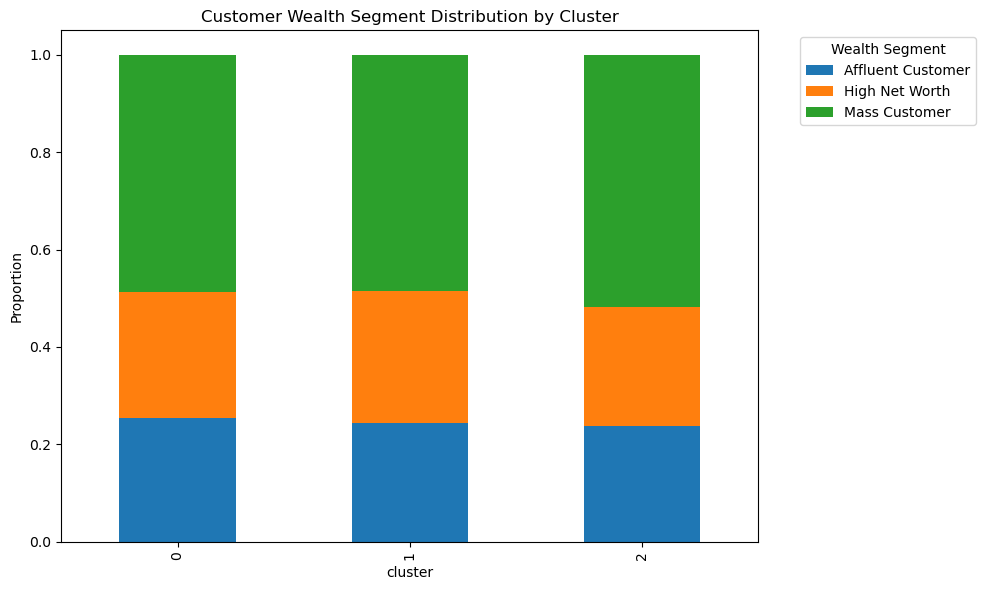

In [131]:
df_for_profiling_no_outliers.groupby('cluster')['wealth_segment'].value_counts(normalize=True).unstack().plot(
    kind='bar', stacked=True, figsize=(10, 6)
)
plt.title("Customer Wealth Segment Distribution by Cluster")
plt.ylabel("Proportion")
plt.legend(title="Wealth Segment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Numerical Profiling 

In [135]:
# List of numerical columns to profile
numerical_cols = [
    'age',
    'past_3_years_bike_related_purchases',
    'property_valuation',
    'total_spent',
    'transaction_count',
    'days_since_last_purchase',
    'customer_tenure_days'
]

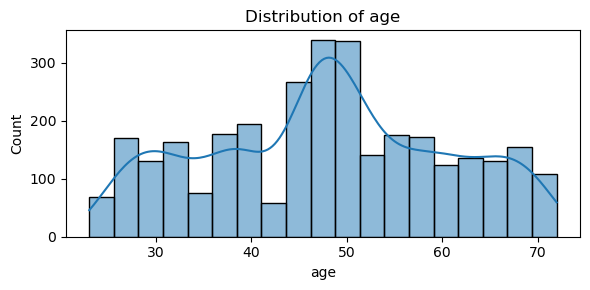

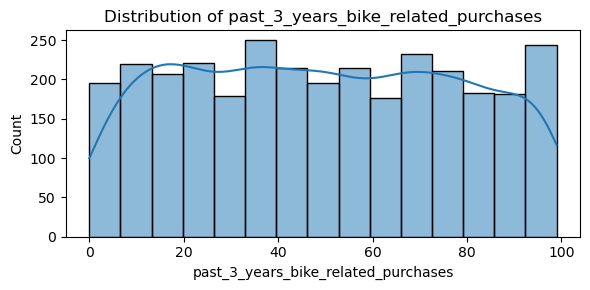

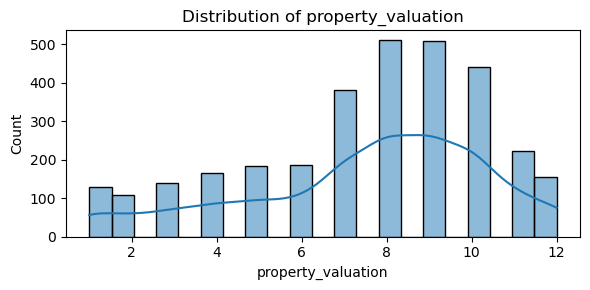

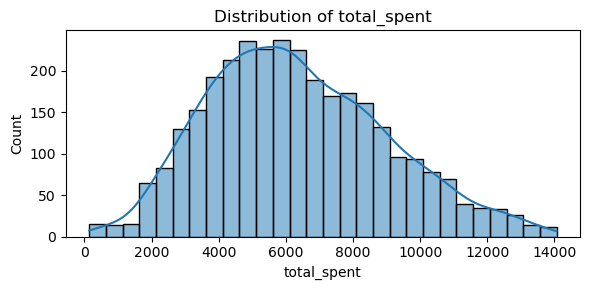

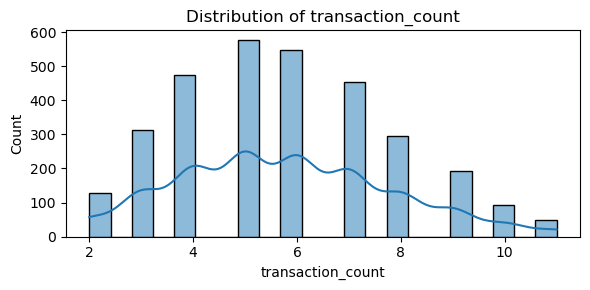

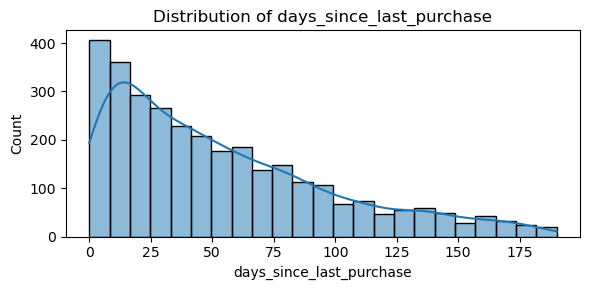

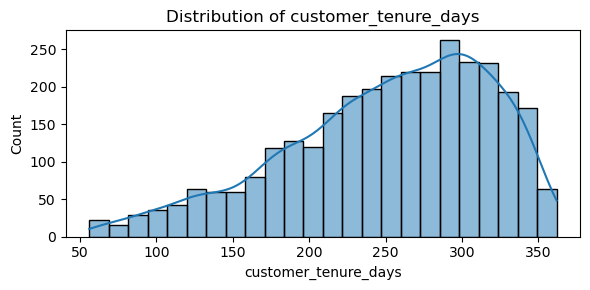

In [137]:
# Histograms with KDE
for col in numerical_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(df_for_profiling_no_outliers[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

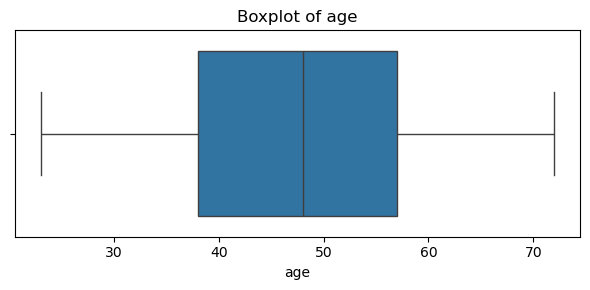

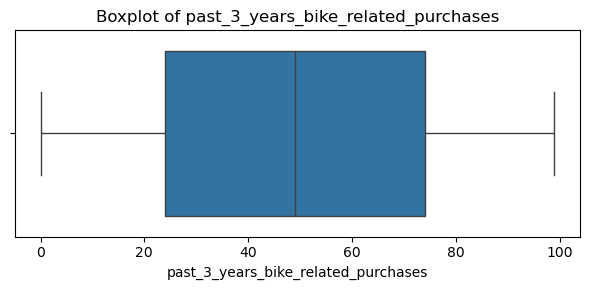

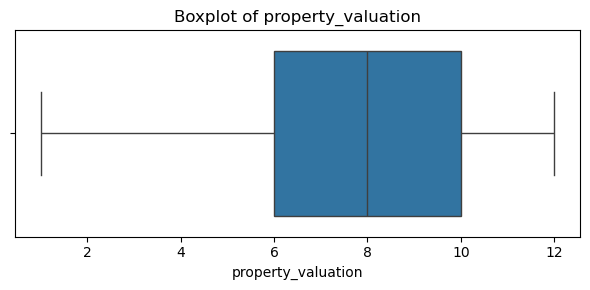

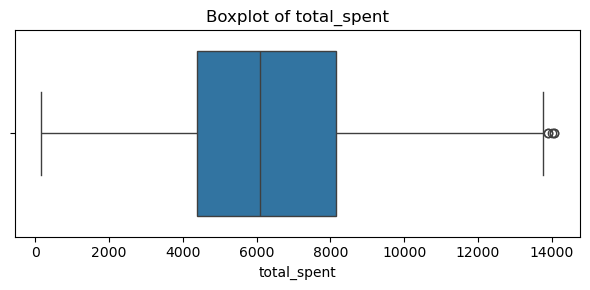

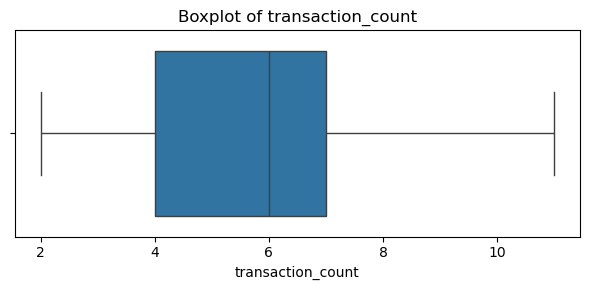

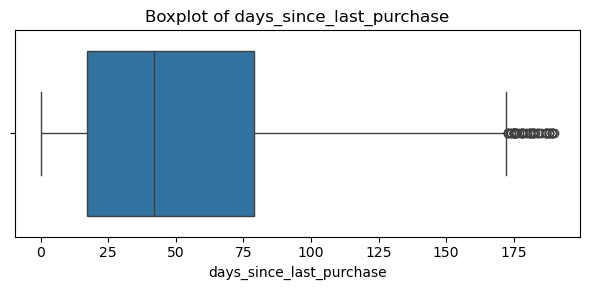

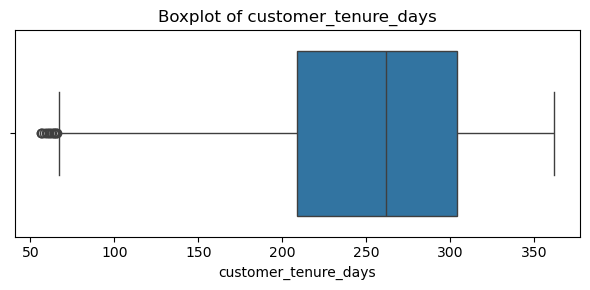

In [139]:
# Boxplots to check outliers
for col in numerical_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df_for_profiling_no_outliers[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

In [141]:
df_for_profiling_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3125 entries, 0 to 3491
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   gender                               3125 non-null   object        
 1   age                                  3125 non-null   float64       
 2   past_3_years_bike_related_purchases  3125 non-null   float64       
 3   job_industry_category                3125 non-null   object        
 4   wealth_segment                       3125 non-null   object        
 5   owns_car                             3125 non-null   object        
 6   state                                3125 non-null   object        
 7   country                              3125 non-null   object        
 8   property_valuation                   3125 non-null   float64       
 9   total_spent                          3125 non-null   float64       
 10  transaction_count

In [143]:
num_cols = [
    "age",
    "past_3_years_bike_related_purchases",
    "property_valuation",
    "total_spent",
    "transaction_count",
    "days_since_last_purchase",
    "customer_tenure_days"
]
num_cols = [c for c in num_cols if c in df.columns]

# Groupby cluster and compute stats
num_profile = (
    df_for_profiling_no_outliers.groupby("cluster")[num_cols]
      .agg(["mean", "median", "min", "max", "std"])
)


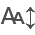

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [147]:
# Make the table for the aggregate values 
from itables import init_notebook_mode, show, options
init_notebook_mode(all_interactive=True)
options.scrollX = True
options.pageLength = 25

show(num_profile, maxBytes=0)

## Exporting Dataset for Tableau

In [149]:
# The Excel file generated below used for Tableau dashboard build

In [151]:
# Exporting Dataset for Tableau
df_for_profiling_no_outliers.to_excel(
    r"C:\Users\willi\OneDrive\Desktop\Capstone Project\final_customer_segments.xlsx", 
    index=False
)